In [48]:
# NUMPY
import numpy as np

# MATPLOTLIB
import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib import rc
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 8, # 12
          'font.size': 8, # 12
          'legend.fontsize': 8, # 12
          'xtick.labelsize': 8, # 10
          'ytick.labelsize': 8, # 10
          'text.usetex': True,
          'figure.figsize': (16, 6)}
plt.rcParams.update(params)

# SEABORN 
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

# SKLEARN 
from sklearn.metrics import pairwise_distances

# POT
import ot
from ot import sinkhorn, emd
# from ot.bregman import sinkhorn, greenkhorn

# PATH 
import sys
path_files = '/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/'
sys.path.insert(0, path_files) 

# GREENKHORN 
# from greenkhorn.sinkhorn import sinkhorn as sinkhgreen
# SCREENKHORN
from screenkhorn.screenkhorn import Screenkhorn
# np.random.seed(3946)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Data generation

In [2]:
n_1 = 1000# nb samples
n_2 = 1000
mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

xs = ot.datasets.make_2D_samples_gauss(n_1, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(n_2, mu_t, cov_t)

a = np.ones((n_1,)) / n_1
b = np.ones((n_2,)) / n_2  # uniform distribution on samples

# loss matrix
M = ot.dist(xs, xt)
M /= M.max()
reg = 0.01

In [3]:
# EMD = emd(a, b, M, numItermax=100000, log=True)
# EMD

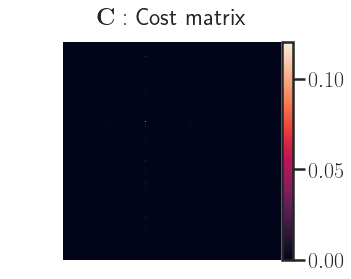

In [4]:
cb_padding = 0.005
fig, ax = plt.subplots(ncols=1) #, figsize=(20,20))
I1 = ax.matshow(np.exp(-M.T/reg))
ax.set_title(r'$\mathbf{C}:$ Cost matrix ')
ax.axis('off')
fig.colorbar(I1, ax=ax, pad=cb_padding, orientation="vertical")
ax.label_outer()

## Greenkhorn from POT

In [5]:
# P_green = greenkhorn(a, b, M, reg, numItermax=1000, stopThr=1e-09, verbose=False, log=False)
# P_green

## Greenkhorn from Altshuler et al

In [6]:
# P_green, _, _ = sinkhgreen(M, a, b, False, M, max_iter=1000)
# (A, r, c, compute_otvals, C, max_iter):
# P_green

## Sinkhorn's algorithm from POT

In [7]:
P_sink = sinkhorn(a, b, M, reg, log=True)

In [8]:
# Print P^star, u_sink = e^{u^star}, v_sink = e^{v^star}
P_star = P_sink[0]
outputs_dict = P_sink[1]
exp_u_star = outputs_dict['u']
exp_v_star = outputs_dict['v']

In [9]:
exp_u_star.shape, P_star.shape, exp_v_star.shape

((1000,), (1000, 1000), (1000,))

## Direct Implementation of Sinkhorn

In [10]:
def sinkhorn_direct(a, b, M, reg, max_iter=5000):
    (n, m) = M.shape
    u_k = np.ones(n)
    v_k = np.ones(m)
    max_iter = 1001
    K = np.exp(-M/reg)
    for k in range(max_iter):
        u_k = np.divide(a, K @ v_k)
        v_k = np.divide(b, K.T @ u_k)
        P_k = (np.diag(u_k) @ K) @ np.diag(v_k) # .reshape(-1)
        sinkhorn_distance = np.sqrt(sum(sum(np.multiply(P_k, K))))
        return P_k, u_k, v_k, sinkhorn_distance

In [11]:
# P_direct = sinkhorn_direct(mu, nu, C, eta, max_iter=5001)
P_direct, u_direct, v_direct, sinkhorn_distance = sinkhorn_direct(a, b, M, reg, max_iter=1000)

In [12]:
u_direct.shape, P_direct.shape, v_direct.shape, sinkhorn_distance

((1000,), (1000, 1000), (1000,), 0.010600758008074126)

## Some plots to get the difference between $P^\star$ from the POT and direct implementation

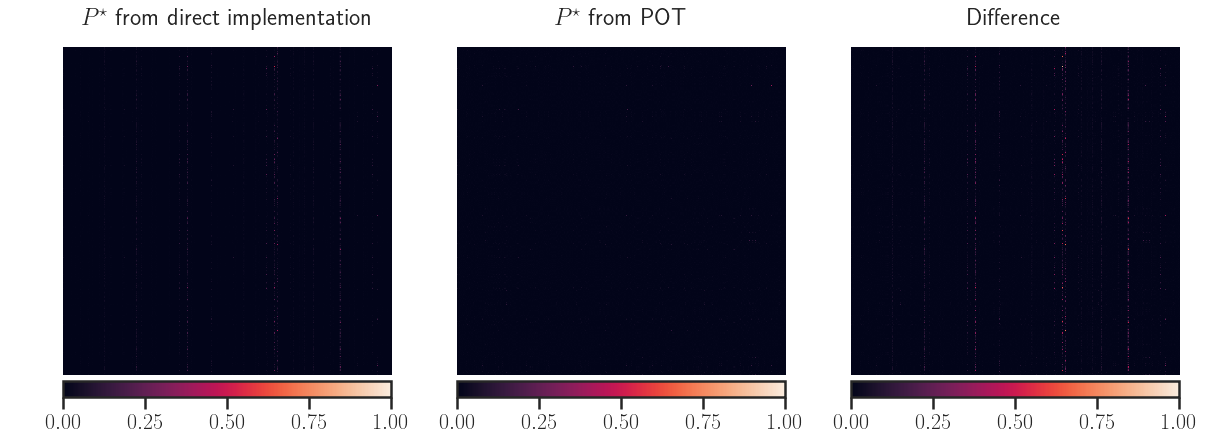

In [13]:
cb_padding = 0.005
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20,20))
I1 = ax1.matshow(np.divide(P_direct.T, P_direct.max()))
ax1.set_title(r'$P^\star$ from direct implementation')
ax1.axis('off')
fig.colorbar(I1, ax=ax1, pad=cb_padding, orientation="horizontal")
ax1.label_outer()
## 
I2 = ax2.matshow(np.divide(P_star.T, P_star.max()))
ax2.set_title(r'$P^\star$ from POT');
# ax2.label_outer()
ax2.axis('off')
fig.colorbar(I2, ax=ax2, pad=cb_padding, orientation="horizontal")
# 
I3 = ax3.matshow(np.divide(np.abs(P_direct.T - P_star.T) , np.abs(P_direct.T - P_star.T).max()))
ax3.set_title('Difference');
# ax3.label_outer()
ax3.axis('off');
fig.colorbar(I3, ax=ax3, pad=cb_padding, orientation="horizontal")
plt.subplots_adjust(hspace=1)

## Screenkhorn

In [14]:
# Initialization
# epsilon = 1e-19
epsilon = 0.
screenkhorn = Screenkhorn(a, b, M, reg, epsilon)

### Plots of $e^{u^\star}$ and $e^{v^\star}$ from POT

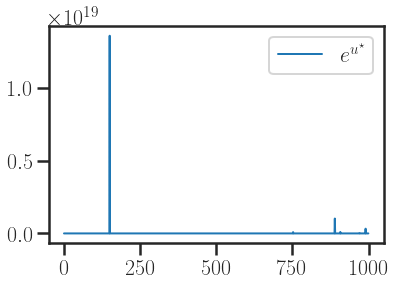

In [15]:
#plt.yscale('log')
plt.plot(exp_u_star, linewidth=2, label=r'$e^{u^\star}$');
plt.legend();

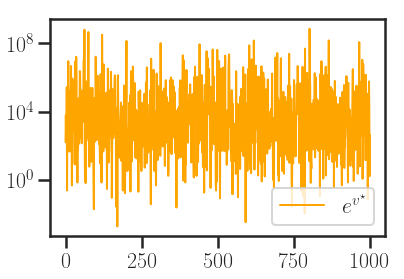

In [16]:
plt.yscale('log')
plt.plot(exp_v_star, linewidth=2, color='orange', label=r'$e^{v^\star}$');
plt.legend();

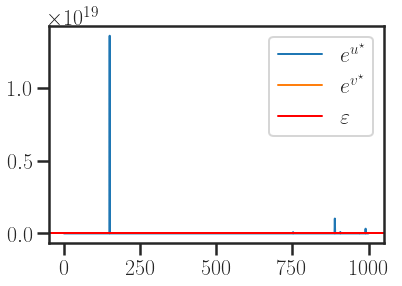

In [17]:
# plt.yscale('log')
plt.plot(exp_u_star, linewidth=2, label=r'$e^{u^\star}$')
plt.plot(exp_v_star, linewidth=2, label=r'$e^{v^\star}$') 
plt.axhline(y= epsilon, linewidth=2, color='r', label=r'$\varepsilon$')
plt.legend();

### $\ell_2$-norm of $e^{u^\star}$ and $e^{v^\star}$

In [18]:
norm2exp_u_star = np.linalg.norm(exp_u_star)
norm2exp_v_star  = np.linalg.norm(exp_v_star)
norm2exp_u_star, "---------", norm2exp_v_star , norm2exp_u_star / norm2exp_v_star

(1.3616423156926235e+19, '---------', 1181210495.3483622, 11527516230.63634)

### Plots of $u^\star$ and $v^\star$

In [19]:
u_star = np.log(exp_u_star)
v_star = np.log(exp_v_star)

# plt.plot(u_star , linewidth=2, label=r'${u^\star}$')
# plt.plot(v_star , linewidth=2, label=r'${v^\star}$') 
# plt.axhline(y =np.log(epsilon), linewidth=2, color='r', label=r'$\log(\varepsilon)$')
# plt.legend(loc='best');

### Choosing of the intervals $I_u$ and $J_u$

In [20]:
I = np.where(exp_u_star >= epsilon)[0].tolist()
#Ic = np.where(exp_v_star < epsilon)[0].tolist()
#len(I), len(Ic)
#Ic

In [21]:
J = np.where(exp_v_star >= epsilon)[0].tolist()
#Jc = np.where(exp_v_star < epsilon)[0].tolist()
#len(J), len(Jc)

In [22]:
# Objective function
# obj = screenkhorn.objective(u_star, v_star, I, J)
# obj

In [23]:
# grad = screenkhorn.grad_objective(u_star, v_star, I, J)
# grad[0], grad[1]

### `screenkhorn = Screening Sinkhorn` potentials vectors by Projected Gradient Descent algorithm

In [24]:
proj_grad = screenkhorn.projected_grad(I, J, max_iter=10000, tol=1e-19, verbose=False)
# proj_grad

/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/screenkhorn/screenkhorn.py:222: RuntimeWarning: divide by zero encountered in log
  u_sc[Ic] = np.array([np.log(self.epsilon)] * len(Ic))
/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/screenkhorn/screenkhorn.py:223: RuntimeWarning: divide by zero encountered in log
  v_sc[Jc] = np.array([np.log(self.epsilon)] * len(Jc))
/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/screenkhorn/screenkhorn.py:82: RuntimeWarning: divide by zero encountered in log
  u_param_Ic = np.array([np.log(self.epsilon)] * card_Ic)
/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/screenkhorn/screenkhorn.py:83: RuntimeWarning: divide by zero encountered in log
  v_param_Jc =  np.array([np.log(self.epsilon)] * card_Jc)
100%|██████████| 10000/10000 [33:18<00:00,  3.97it/s]

counting cp:  79314


### Curve of the objective function

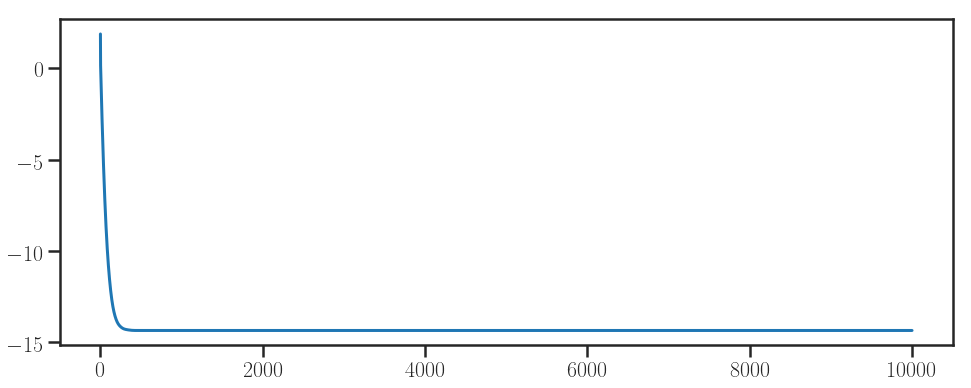

In [49]:
obj = list(proj_grad[2].values())

obj = np.asarray(obj)
obj = obj.T
obj.shape = (len(obj,))
plt.plot(obj);

In [26]:
obj[-1]

-14.35562113384544

### Sort of the solution by `screenkhorn` $e^{u_\text{sc}}$

In [27]:
# proj_grad[2]

In [50]:
v_star.shape, proj_grad[0][:5]

((1000,), array([  5.91278369,   0.71941695,  21.26394402, -12.67494181,
          4.03085695]))

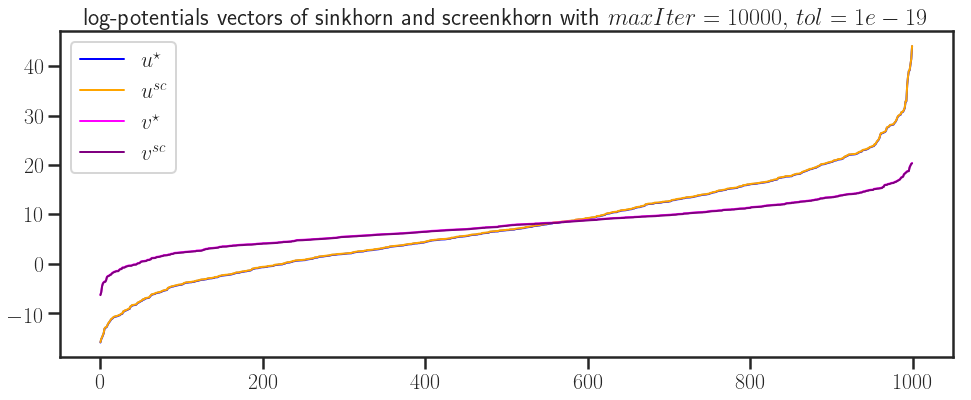

In [71]:
plt.plot(np.sort(u_star), 'blue', linewidth=2, label =r'${u^\star}$')
plt.plot(np.sort(proj_grad[0]), 'orange', linewidth=2, label =r'${u^{{sc}}}$')
plt.plot(np.sort(v_star), 'magenta', linewidth=2, label =r'${v^\star}$')
plt.plot(np.sort(proj_grad[1]), 'purple', linewidth=2, label =r'${v^{{sc}}}$')
# plt.axhline(y =np.log(epsilon), linewidth=, color='r', label=r'$\log(\varepsilon)$');
plt.legend(loc='best');
plt.title(r'log-potentials vectors of sinkhorn and screenkhorn with ${maxIter}=10000,\,tol=1e-19$')
plt.savefig(r'Potentials vectors of sinkhorn and screenkhorn.pdf', bbox_inches='tight')
plt.show();

In [61]:
# plt.plot(np.sort(u_star), 'blue', linewidth=2, label =r'${u^\star}$')
# plt.plot(np.sort(proj_grad[0]), 'orange', linewidth=2, label =r'${u^{{sc}}}$')
# plt.plot(np.sort(v_star), 'magenta', linewidth=2, label =r'${v^\star}$')
# plt.plot(np.sort(proj_grad[1]), 'purple', linewidth=2, label =r'${v^{{sc}}}$')
# plt.axhline(y =np.log(epsilon), linewidth=, color='r', label=r'$\log(\varepsilon)$');
# plt.legend();

## Verification of $$e^{{u_\text{sc}}_{I_u}} = \log(\varepsilon)$$

In [31]:
# x[Ic] == np.log(epsilon)

## Estimated marginals 

$$ P^{sc} = \Delta(e^{u_{sc}}) K \Delta(e^{v_{sc}})$$

In [32]:
# e^{u_{\text{sc}} K e^{v_{\text{sc}}$$
## Marginals 
K = np.exp(- screenkhorn.M / screenkhorn.reg)
u_sc = proj_grad[0]
u_sc.shape=(n_1,)
v_sc = proj_grad[1]
v_sc.shape=(n_2,)
P_sc = np.diag(np.exp(u_sc)) @ K @ np.diag(np.exp(v_sc))
# P_star[:20], "\n", P_sc[:20]

In [52]:
norm2u_sc = np.linalg.norm(np.exp(u_sc))
norm2v_sc = np.linalg.norm(np.exp(v_sc))

print(norm2u_sc, "\t", norm2exp_u_star)
print("\n")
print(norm2v_sc, "\t", norm2exp_v_star)

print("\n")
print(norm2u_sc / norm2v_sc, "\t", norm2exp_u_star /norm2exp_v_star)

1.4663350544734982e+19 	 1.3616423156926235e+19


1097630019.1760511 	 1181210495.3483622


13359101234.98827 	 11527516230.63634


In [53]:
norm2u_sc/norm2exp_u_star,  norm2v_sc/norm2exp_v_star

(1.0768871072632764, 0.9292416749584828)

### Gap between true and estimated marginals 

In [54]:
a_sc = P_sc @ np.ones(len(v_sc))
b_sc = P_sc.T @ np.ones(len(u_sc))
# print(np.abs(a - a_sc))
#plt.plot(a)
#plt.plot(np.abs(a - a_sc));
# print('-------------- Marginals giv')

print(a[:30]) 
print("\n")
print(a_sc[:30]) 
print("\n")
sum(a_sc)

[0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001]


[0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001]




1.0000000000000002

In [55]:
print(b[:30]) 
print("\n")
print(b_sc[:30]) 
print("\n")
sum(b_sc)
#b[:30] - b_sc[:30]

[0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001]


[0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001]




1.0000000000000002

In [56]:
a_star = P_star @ np.ones(n_2)
b_star = P_star.T @ np.ones(n_1)

In [57]:
abs(1 - sum(a_sc)),  "\n\n", abs(1 - sum(b_sc))

(2.220446049250313e-16, '\n\n', 2.220446049250313e-16)

In [59]:
abs(1 - sum(a_star)), abs(1- sum(b_star))

(6.661338147750939e-16, 6.661338147750939e-16)

In [40]:
#a[:-30]- a_sc[:-30]

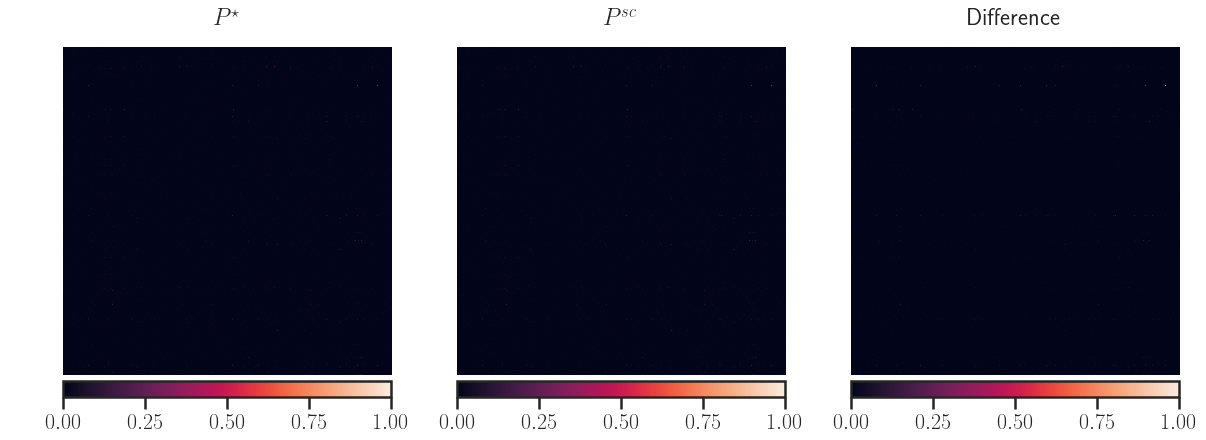

In [41]:
cb_padding = 0.005
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20,20))
I1 = ax1.matshow(np.divide(P_star.T, P_star.max()))
ax1.set_title(r'$P^\star$')
ax1.axis('off')
fig.colorbar(I1, ax=ax1, pad=cb_padding, orientation="horizontal")
ax1.label_outer()
## 
I2 = ax2.matshow(np.divide( P_sc.T,  P_sc.T.max()))
ax2.set_title(r'$P^{sc}$');
# ax2.label_outer()
ax2.axis('off')
fig.colorbar(I2, ax=ax2, pad=cb_padding, orientation="horizontal")
# 
I3 = ax3.matshow(np.divide(np.abs(P_sc.T - P_star.T) , np.abs(P_sc.T - P_star.T).max()))
ax3.set_title('Difference');
# ax3.label_outer()
ax3.axis('off');
fig.colorbar(I3, ax=ax3, pad=cb_padding, orientation="horizontal")
plt.subplots_adjust(hspace=1)

In [42]:
P_sc[:5, :5]

array([[1.22791706e-06, 1.89995220e-07, 3.54774769e-07, 1.05000852e-07,
        1.41557550e-07],
       [5.82472442e-08, 1.39698322e-09, 3.68060448e-09, 3.71376076e-10,
        1.41600808e-09],
       [1.60531900e-07, 7.20131084e-07, 8.74438010e-07, 2.11417895e-06,
        2.21352546e-07],
       [2.16436826e-07, 4.09489218e-07, 1.48812156e-07, 7.13836373e-08,
        1.52255009e-06],
       [2.45151152e-07, 2.03626848e-06, 1.08080476e-06, 2.07770513e-06,
        1.93105776e-06]])

In [43]:
P_star[:5, :5]

array([[1.22884028e-06, 1.90368327e-07, 3.55339390e-07, 1.05233530e-07,
        1.41841765e-07],
       [5.83633983e-08, 1.40146414e-09, 3.69103836e-09, 3.72661065e-10,
        1.42061240e-09],
       [1.60198734e-07, 7.19506798e-07, 8.73355341e-07, 2.11287783e-06,
        2.21170366e-07],
       [2.16461381e-07, 4.10031620e-07, 1.48953906e-07, 7.14961818e-08,
        1.52463378e-06],
       [2.44713787e-07, 2.03509716e-06, 1.07978171e-06, 2.07703264e-06,
        1.93003172e-06]])

In [44]:
np.sqrt(sum(sum(np.multiply(P_star, M)))) - u_star @ a - v_star @ b

-14.821870080924832

In [45]:
np.sqrt(sum(sum(np.multiply(P_sc, M)))) - u_sc @ a - v_sc @ b

-14.821869736739952

In [46]:
np.sqrt(sum(sum(np.multiply(P_star, M)))) - np.sqrt(sum(sum(np.multiply(P_sc, M))))

-7.292918263734904e-07

In [47]:
np.sqrt(sum(sum(np.multiply(P_star, M)))) - u_star @ a - v_star @ b\
- np.sqrt(sum(sum(np.multiply(P_sc, M)))) + u_sc @ a + v_sc @ b

-3.4418488148446613e-07